# NiBabel Tutorial

In [23]:
from __future__ import print_function

import sys
import os
import numpy as np
import nibabel as nib
import nilearn as nl

# Image settings
import nilearn.plotting
import matplotlib as mpl
import pylab as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline
mpl.rcParams['font.family'] = 'DejaVu Sans'

# Assumed working directory
os.chdir("/")

In [24]:
print("Python version:", sys.version.split()[0])
print("nibabel version: {} (Commit: {})".format(nib.__version__, open(os.path.join(os.path.dirname(nib.__file__), 'COMMIT_INFO.txt')).readlines()[1].split()[2]))
print("nilearn version:", nilearn.__version__)

Python version: 3.6.2
nibabel version: 2.1.0 (Commit: $Format:%h$)
nilearn version: 0.3.1


Finally, let's make sure you have the data directory.

To avoid polluting the working directory we're sharing with other lessons, let's set up a derivatives directory for this tutorial.

In [25]:
out_dir = 'data/ds000114/derivatives/nibabel_nilearn_tutorial'
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)

##Nibabel

Nibabel is a low-level Python library that gives access to a variety of imaging formats, with a particular focus on providing a common interface to the various volumetric formats produced by scanners and used in common neuroimaging toolkits.

- NIfTI-1
- NIfTI-2
- SPM Analyze
- FreeSurfer .mgh/.mgz files
- Philips PAR/REC
- Siemens ECAT
- DICOM (limited support)

It also supports surface file formats

    -GIFTI
    -FreeSurfer surfaces, labels and annotations

Connectivity

    -CIFTI-2 (next release!)

Tractocgraphy

    - TrackViz .trk files

And a number of related formats.

Almost all of these can be loaded through the nibabel.load interface.

In [26]:
t1 = nib.load('/data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz')
print(t1)

<class 'nibabel.nifti1.Nifti1Image'>
data shape (256, 156, 256)
affine: 
[[  9.99131918e-01  -5.16291820e-02   1.25127016e-02  -1.25263863e+02]
 [  4.07721959e-02   1.29202044e+00  -9.81179178e-02  -7.31330109e+01]
 [ -8.54506902e-03   1.28044292e-01   9.95096147e-01  -1.77554291e+02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 256 156 256   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [ 1.          1.          1.29937589  1.          0.009668    0.          0.
  0.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unkno

This data-affine-header structure is common to volumetric formats in nibabel, though the details of the header will vary from format to format.

These objects can be accessed through the following interfaces.

In [27]:
data = t1.get_data()
affine = t1.affine
header = t1.header

Aside
Why not just t1.data? Working with neuroimages can use a lot of memory, so nibabel works hard to be memory efficient. If it can read some data while leaving the rest on disk, it will. t1.get_data() reflects that it's doing some work behind the scenes.

Data
The data is a simple numpy array. It has a shape, it can be sliced and generally manipulated as you would any array.


In [32]:
print(data.shape)


(256, 156, 256)


<OrthoSlicer3D: /data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz (256, 156, 256)>

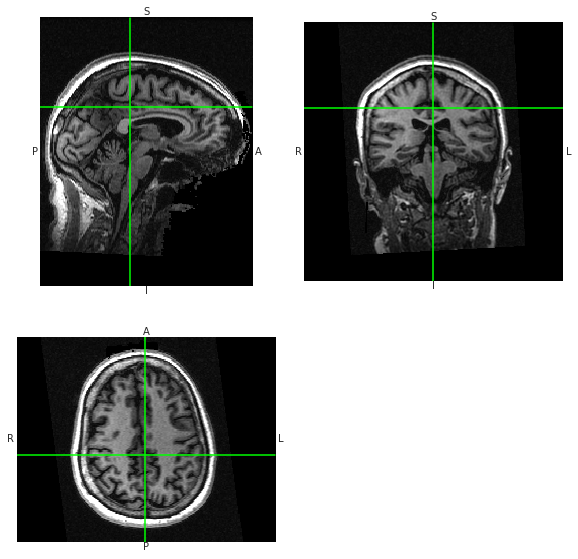

In [33]:
t1.orthoview()

Quirk

``img.()`` shows the type of the data on disk

`img.get_data().dtype` shows the type of the data that you're working with

These are not always the same, and not being clear on this has caused problems. Further, modifying one does not update the other. This is especially important to keep in mind later, when saving files.

In [30]:
print((data.dtype, t1.get_data_dtype()))

(dtype('<f4'), dtype('<f4'))


Warning

`img.orthoview()` may not work properly on OS X.

Affine

The affine is a 4 x 4 numpy array. This describes the transformation from the voxel space (indices [i, j, k]) to the reference space (distance in mm (x, y, z)).

It can be used, for instance, to discover the voxel that contains the origin of the image:

In [31]:
x, y, z, _ = np.linalg.pinv(affine).dot(np.array([0, 0, 0, 1])).astype(int)

print("Affine:")
print(affine)
print
print("Center: ({:d}, {:d}, {:d})".format(x, y, z))

Affine:
[[  9.99131918e-01  -5.16291820e-02   1.25127016e-02  -1.25263863e+02]
 [  4.07721959e-02   1.29202044e+00  -9.81179178e-02  -7.31330109e+01]
 [ -8.54506902e-03   1.28044292e-01   9.95096147e-01  -1.77554291e+02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]
Center: (126, 65, 171)


In [16]:
!nib-ls -H descrip /data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz

/data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz float32 [256, 156, 256] 1.00x1.30x1.00   b'FSL5.0' sform



## Creating and saving images
Suppose we want to save space by rescaling our image to a smaller datatype, such as an unsigned byte. To do this, we create a new image with a modified data array, and copy over the old affine and header. We then use the img.to_filename() method to save.

In [20]:
rescaled = ((data - data.min()) * 255. / (data.max() - data.min())).astype(np.uint8)
rescaled_img = nib.Nifti1Image(rescaled, affine=affine, header=header)

print((rescaled_img.get_data().dtype, rescaled_img.get_data_dtype()))

(dtype('uint8'), dtype('<f4'))


Our data array has the correct type, but the on-disk format is determined by the header, so saving now will not do what we want.

In [21]:
rescaled_img.to_filename(os.path.join(out_dir, 'rescaled1.nii.gz'))
test = nib.load(os.path.join(out_dir, 'rescaled1.nii.gz'))
print((test.get_data().dtype, test.get_data_dtype()))

(dtype('<f4'), dtype('<f4'))


Instead, we need to set the data type in the header using img.set_data_dtype():

In [22]:
rescaled_img.set_data_dtype(np.uint8)
rescaled_img.to_filename(os.path.join(out_dir, 'rescaled2.nii.gz'))
test = nib.load(os.path.join(out_dir, 'rescaled2.nii.gz'))
print((test.get_data().dtype, test.get_data_dtype()))

# Check that our data is what we think it is
assert np.array_equal(test.get_data(), rescaled)

(dtype('uint8'), dtype('uint8'))
